In [291]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from RNN_utils import *
from RNN_Model import RnnModel, train_rnn_model

import warnings
warnings.filterwarnings("ignore")

weekly = pd.read_csv('../../../Dataset/Boulder_Weekly.csv')
weekly['Date'] = pd.to_datetime(weekly['Date'])
weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           239 non-null    datetime64[ns]
 1   Energy__kWh_   239 non-null    float64       
 2   Day            239 non-null    int64         
 3   Minimum T      239 non-null    int64         
 4   Maximum T      239 non-null    int64         
 5   Snow           239 non-null    float64       
 6   Precipitation  239 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 13.2 KB


In [292]:
if weekly['Date'].is_monotonic_increasing == False:
    weekly.sort_values(by='Date', ascending=True, inplace=True)

weekly['Month'] = weekly['Date'].dt.month_name()
weekly.drop(columns={'Date', 'Day'}, inplace=True)

In [293]:
weekly

,Energy__kWh_,Minimum T,Maximum T,Snow,Precipitation,Month
0,151.294,590,1288,0.0000,0.000000,January
1,275.012,1160,2110,0.0000,1310.965120,January
2,267.165,809,2053,260554.3176,22941.889600,January
3,455.483,1616,3522,0.0000,0.000000,January
4,436.939,1547,3314,88490.1456,5407.731120,February
...,...,...,...,...,...,...
234,3648.697,21235,33678,0.0000,113539.411630,July
235,3146.682,19476,31395,0.0000,220941.867793,July
236,3797.209,24846,38266,0.0000,316658.708617,July
237,3487.422,24324,36154,0.0000,615006.511920,July


## **Preprocessing**

    Divided the dataset into training, testing, and validation datasets according to 0.70, 0.20, and 0.10, respectively.

In [294]:
train_weekly, val_weekly, test_weekly = split_dataset(weekly, train_ratio=0.7, val_ratio=0.2)

Training split ratio:   0.699
Validation split ratio: 0.197
Testing split ratio:    0.105

Shapes of the datasets:
(167, 6) (47, 6) (25, 6)


In [295]:
train_weekly

,Energy__kWh_,Minimum T,Maximum T,Snow,Precipitation,Month
0,151.294,590,1288,0.000000e+00,0.000000,January
1,275.012,1160,2110,0.000000e+00,1310.965120,January
2,267.165,809,2053,2.605543e+05,22941.889600,January
3,455.483,1616,3522,0.000000e+00,0.000000,January
4,436.939,1547,3314,8.849015e+04,5407.731120,February
...,...,...,...,...,...,...
162,725.122,277,1426,6.122863e+05,41728.019770,February
163,902.382,1144,4199,1.697503e+06,125482.303874,February
164,963.962,2312,5182,1.614126e+06,110263.637537,February
165,997.212,2994,6442,0.000000e+00,2433.479004,March


    One Hot Encode

In [296]:
# One-hot encode 'Month' column for train_weekly and drop 'Month' column after one-hot encoding
train_weekly = one_hot_months(train_weekly)
train_weekly.drop(columns=['Month'], inplace=True)

# One-hot encode 'Month' column for val_weekly and drop 'Month' column after one-hot encoding
val_weekly = one_hot_months(val_weekly)
val_weekly.drop(columns=['Month'], inplace=True)

# One-hot encode 'Month' column for test_weekly and drop 'Month' column after one-hot encoding
test_weekly = one_hot_months(test_weekly)
test_weekly.drop(columns=['Month'], inplace=True)

In [297]:
train_weekly.head(15)

,Energy__kWh_,Minimum T,Maximum T,Snow,Precipitation,January,February,March,April,May,June,July,August,September,October,November,December
0,151.294,590,1288,0.000000e+00,0.000000,1,0,0,0,0,0,0,0,0,0,0,0
1,275.012,1160,2110,0.000000e+00,1310.965120,1,0,0,0,0,0,0,0,0,0,0,0
2,267.165,809,2053,2.605543e+05,22941.889600,1,0,0,0,0,0,0,0,0,0,0,0
3,455.483,1616,3522,0.000000e+00,0.000000,1,0,0,0,0,0,0,0,0,0,0,0
4,436.939,1547,3314,8.849015e+04,5407.731120,0,1,0,0,0,0,0,0,0,0,0,0
5,487.344,1557,3502,5.339233e+05,30450.442325,0,1,0,0,0,0,0,0,0,0,0,0
6,617.824,1855,3840,1.440259e+05,10779.410699,0,1,0,0,0,0,0,0,0,0,0,0
7,717.055,712,2735,1.569635e+06,85843.634764,0,1,0,0,0,0,0,0,0,0,0,0
8,576.041,1889,4253,0.000000e+00,0.000000,0,0,1,0,0,0,0,0,0,0,0,0
9,480.290,1898,4149,0.000000e+00,0.000000,0,0,1,0,0,0,0,0,0,0,0,0


    Create sequences for the RNNs model

In [298]:
# Define the time window size
sequence_length = 22

# Create sequences for training data
X_train, Y_train = create_sequences(train_weekly, sequence_length, 'Energy__kWh_', step=1)
# Create sequences for validation data
X_val, Y_val = create_sequences(val_weekly, sequence_length, 'Energy__kWh_', step=1)
# Create sequences for test data
X_test, Y_test = create_sequences(test_weekly, sequence_length, 'Energy__kWh_', step=1)

Dataset split into sequences:
Sequences shape: (145, 22, 17)
Targets shape: (145,)

Dataset split into sequences:
Sequences shape: (25, 22, 17)
Targets shape: (25,)

Dataset split into sequences:
Sequences shape: (3, 22, 17)
Targets shape: (3,)



**Scalling the Numerical columns**

    Scaling the X_train and Y_train

In [299]:
# We scale also with MinMaxScaler this columns ['Energy__kWh_', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow']
numerical_D = len(['Energy__kWh_', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow'])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# ----------------------
#    SCALE THE X_train
# ----------------------

# Extract the first 5 columns from X_train
X_train_subset = X_train[:, :, :numerical_D]

# Reshape the subset to 2D array
X_train_subset_2d = X_train_subset.reshape(-1, numerical_D)

# Fit the scaler on the subset and transform it
x_scaler = scaler.fit_transform(X_train_subset_2d)

# Reshape the scaled subset back to the original shape
X_train_scaled_subset = x_scaler.reshape(X_train.shape[0], X_train.shape[1], numerical_D)

# Combine the scaled subset with the remaining columns of X_train
X_train_scaled = np.concatenate([X_train_scaled_subset, X_train[:, :, 5:]], axis=-1)


# ----------------------
#    SCALE THE Y_train
# ----------------------

# Reshape the subset to 2D array
Y_train_reshaped = Y_train.reshape(-1,1)

# Add extra columns of zeros to match the expected dimension for concatenation
Y_train_reshaped = np.concatenate((Y_train_reshaped, np.zeros((Y_train_reshaped.shape[0], numerical_D-1))), axis=1)

# Use the previously fitted scaler to transform the Y_train_reshaped
Y_train_scaled = scaler.transform(Y_train_reshaped)

# Keep only the energy column (target) in the Y_train_scaled
Y_train_scaled = Y_train_scaled[:,:1]

    Scaling the X_val, X_test and Y_val, Y_test accord to X_train MinMaxScaler

In [300]:
X_val_scaled, Y_val_scaled = scale_data_with_fitted_scaler(scaler, X_val, Y_val, numerical_D)
X_test_scaled, Y_test_scaled = scale_data_with_fitted_scaler(scaler, X_test, Y_test, numerical_D)

print('Train Dataset:')
print("scaled X_train shape:", X_train_scaled.shape)
print("scaled Y_train shape:", Y_train_scaled.shape)

print('\nValidation Dataset:')
print("scaled X_val shape:", X_val_scaled.shape)
print("scaled Y_val shape:", Y_val_scaled.shape)

print('\nTest Dataset:')
print("scaled X_test shape:", X_test_scaled.shape)
print("scaled Y_test shape:", Y_test_scaled.shape)

Train Dataset:
scaled X_train shape: (145, 22, 17)
scaled Y_train shape: (145, 1)

Validation Dataset:
scaled X_val shape: (25, 22, 17)
scaled Y_val shape: (25, 1)

Test Dataset:
scaled X_test shape: (3, 22, 17)
scaled Y_test shape: (3, 1)


    Create the RNNs Models

In [301]:
# Define the input shape for the models ||  input_shape = (sequence_length, num_features)
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])

# Create LSTM model
# Define the default regularation l2=0.01  ||  If we want we can train the model without regularations. (regularization = 0)
lstm = RnnModel('LSTM', input_shape, num_layers=3, num_units=128, regularization=0.01)

# Create Simple RNN model
simple_rnn = RnnModel('SimpleRNN', input_shape, num_layers=3, num_units=128, regularization=0.01)

# Create Bi-LSTM model
bi_lstm = RnnModel('Bi-LSTM', input_shape, num_layers=3, num_units=64, regularization=0.01)

# Create GRU model
gru = RnnModel('GRU', input_shape, num_layers=3, num_units=63, regularization=0.01)

In [302]:
# Print summaries of the configurations
print("LSTM Summary:")
lstm.summary()
print()

print("Simple RNN Summary:")
simple_rnn.summary()
print()

print("Bi-LSTM Summary:")
bi_lstm.summary()
print()

print("GRU Summary:")
gru.summary()

LSTM Summary:
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_90 (LSTM)              (None, 22, 128)           74752     
                                                                 
 lstm_91 (LSTM)              (None, 22, 128)           131584    
                                                                 
 lstm_92 (LSTM)              (None, 128)               131584    
                                                                 
 dense_60 (Dense)            (None, 1)                 129       
                                                                 
Total params: 338,049
Trainable params: 338,049
Non-trainable params: 0
_________________________________________________________________

Simple RNN Summary:
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              

    Compile the Models

In [303]:
# Define the learning rate for Adam optimizer
learning_rate = 0.001

# Compile each RNN model
lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae', 'mse', root_mean_squared_error])

simple_rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae', 'mse', root_mean_squared_error])

bi_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae', 'mse', root_mean_squared_error])

gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae', 'mse', root_mean_squared_error])

    Train the Models

In [304]:
# Define the parameters for training
lstm_epochs = 50
simple_rnn_epochs = 100
bi_lstm_epochs, gru_epochs = 200, 200
batch_size = 32

# Train each RNN model
print('-----------------\nLSTM Training\n-----------------\n')
lstm_history = train_rnn_model(lstm, X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, lstm_epochs, batch_size)

print('\n-----------------\nSimpleRNN / Vanilla RNN Training\n-----------------\n')
simple_rnn_history = train_rnn_model(simple_rnn, X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, simple_rnn_epochs, batch_size)

print('\n-----------------\nBi-LSTM Training\n-----------------\n')
bi_lstm_history = train_rnn_model(bi_lstm, X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, bi_lstm_epochs, batch_size)

print('\n-----------------\nGRU Training\n-----------------\n')
gru_history = train_rnn_model(gru, X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, gru_epochs, batch_size)

-----------------
LSTM Training
-----------------



Epoch 1/50
5/5 [==============================] - 39s 2s/step - loss: 11.8065 - mae: 0.2712 - mse: 0.1272 - root_mean_squared_error: 0.3040 - val_loss: 10.9722 - val_mae: 0.1966 - val_mse: 0.0517 - val_root_mean_squared_error: 0.2274
Epoch 2/50
5/5 [==============================] - 2s 485ms/step - loss: 10.5638 - mae: 0.1615 - mse: 0.0424 - root_mean_squared_error: 0.2087 - val_loss: 10.0007 - val_mae: 0.3816 - val_mse: 0.1658 - val_root_mean_squared_error: 0.4072
Epoch 3/50
5/5 [==============================] - 2s 435ms/step - loss: 9.5253 - mae: 0.1639 - mse: 0.0435 - root_mean_squared_error: 0.2031 - val_loss: 8.9078 - val_mae: 0.1380 - val_mse: 0.0294 - val_root_mean_squared_error: 0.1715
Epoch 4/50
5/5 [==============================] - 2s 436ms/step - loss: 8.5983 - mae: 0.1319 - mse: 0.0299 - root_mean_squared_error: 0.1717 - val_loss: 8.0740 - val_mae: 0.1495 - val_mse: 0.0344 - val_root_mean_squared_error: 0.1856
Epoch 5/50
5/5 [==============================] - 3s 565ms/ste

    Evaluate the Models

In [305]:
def evaluate_model(model, model_name, X_train, Y_train, X_val, Y_val, X_test, Y_test):
    train_eval = model.evaluate(X_train, Y_train, verbose=0)
    val_eval = model.evaluate(X_val, Y_val, verbose=0)
    test_eval = model.evaluate(X_test, Y_test, verbose=0)

    print(f'\nEvaluation metrics for {model_name} model:\n-------------------')
    print('Training Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}\n'.format(train_eval[0], train_eval[3], train_eval[1], train_eval[2]))
    print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}\n'.format(val_eval[0], val_eval[3], val_eval[1], val_eval[2]))
    print('Test Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}'.format(test_eval[0], test_eval[3], test_eval[1], test_eval[2]),'\n')

evaluate_model(lstm, 'LSTM',X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test_scaled, Y_test_scaled)
evaluate_model(simple_rnn, 'RNN',X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test_scaled, Y_test_scaled)
evaluate_model(bi_lstm, 'Bi-LSTM',X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test_scaled, Y_test_scaled)
evaluate_model(gru, 'GRU',X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test_scaled, Y_test_scaled)


Evaluation metrics for LSTM model:
-------------------
Training Data - Loss: 2.2838, MAE: 0.1422, RMSE: 0.1122, MSE: 0.0221

Validation Data - Loss: 2.2884, MAE: 0.1634, RMSE: 0.1288, MSE: 0.0267

Test Data - Loss: 2.4741, MAE: 0.4609, RMSE: 0.4532, MSE: 0.2124 


Evaluation metrics for RNN model:
-------------------
Training Data - Loss: 0.6740, MAE: 0.1011, RMSE: 0.0808, MSE: 0.0126

Validation Data - Loss: 0.6809, MAE: 0.1398, RMSE: 0.1129, MSE: 0.0195

Test Data - Loss: 0.7377, MAE: 0.2763, RMSE: 0.2650, MSE: 0.0763 


Evaluation metrics for Bi-LSTM model:
-------------------
Training Data - Loss: 0.3019, MAE: 0.1253, RMSE: 0.1016, MSE: 0.0179

Validation Data - Loss: 0.3172, MAE: 0.1824, RMSE: 0.1416, MSE: 0.0333

Test Data - Loss: 0.4371, MAE: 0.3913, RMSE: 0.3824, MSE: 0.1532 


Evaluation metrics for GRU model:
-------------------
Training Data - Loss: 0.0269, MAE: 0.1130, RMSE: 0.0918, MSE: 0.0150

Validation Data - Loss: 0.0341, MAE: 0.1491, RMSE: 0.1131, MSE: 0.0222

Test D

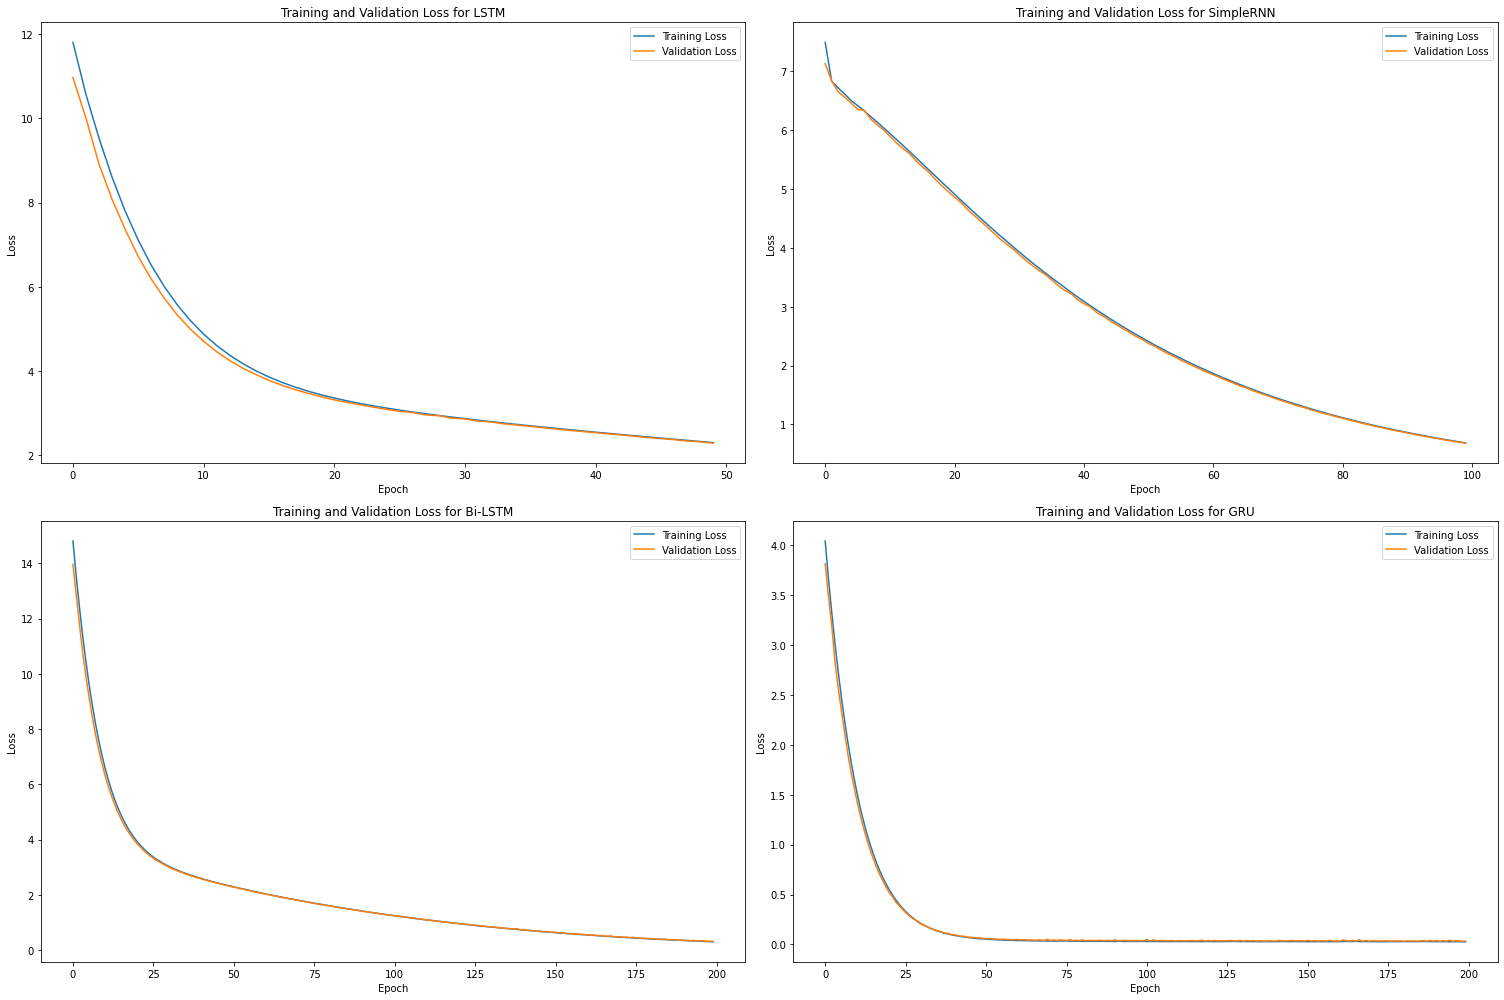

In [306]:
def plot_loss(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss for ' + model_name)
    ax.legend()


fig, axes = plt.subplots(2, 2, figsize=(21, 14))
axes = axes.flatten()

histories = []
model_names = ['LSTM', 'SimpleRNN', 'Bi-LSTM', 'GRU']
histories.extend([lstm_history, simple_rnn_history, bi_lstm_history, gru_history])

for i, (history, model_name) in enumerate(zip(histories, model_names)):
    plot_loss(history, model_name, axes[i])

# Hide empty subplots
for i in range(len(histories), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

    Make predictions with Train, Validation and Test Dataset and evaluate them with MAE and RMSE

In [307]:
evaluate_predictions_model(lstm, 'LSTM', X_train_scaled, Y_train, X_val_scaled, Y_val, X_test_scaled, Y_test, scaler)
evaluate_predictions_model(simple_rnn, 'RNN', X_train_scaled, Y_train, X_val_scaled, Y_val, X_test_scaled, Y_test, scaler)
evaluate_predictions_model(bi_lstm, 'Bi-LSTM', X_train_scaled, Y_train, X_val_scaled, Y_val, X_test_scaled, Y_test, scaler)
evaluate_predictions_model(gru, 'GRU', X_train_scaled, Y_train, X_val_scaled, Y_val, X_test_scaled, Y_test, scaler)

1/1 [==============================] - 0s 146ms/step


Evaluation metrics for LSTM model:
-------------------
Train Dataset:
RMSE: 326.4257971185583
MAE: 246.09787046304734
-------------------
Validation Dataset:
RMSE: 358.53902353470437
Validation MAE: 282.5275156773711
-------------------
Test Dataset:
Test RMSE: 1011.1363038031197
Test MAE: 994.3339946530659


1/1 [==============================] - 0s 90ms/step


Evaluation metrics for RNN model:
-------------------
Train Dataset:
RMSE: 246.47417359764657
MAE: 177.23470351949962
-------------------
Validation Dataset:
RMSE: 306.6620793970327
Validation MAE: 247.68713091306688
-------------------
Test Dataset:
Test RMSE: 606.094998212073
Test MAE: 581.3721086087227


1/1 [==============================] - 0s 156ms/step


Evaluation metrics for Bi-LSTM model:
-------------------
Train Dataset:
RMSE: 293.6220207944002
MAE: 222.98475632254298
-------------------
Validation Dataset:
RMSE: 400.154221387768
Validation MAE: 310.571940242457